In [1]:
import os
os.chdir('..')

In [2]:
import torch
import pickle
import numpy as np

from gnn_library.util import load
from evaluate import evaluate_model
from instance_generator import sample_instances
from params import *
from util import _plot_approx_ratios_all

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

GNN, args = load('GNN2_hyperparam_tuned', device)

PyTorch has version 1.12.0+cu102
Using device: cuda


## Size generalization experiment

#### Evaluate CRs for all graph configurations across different graph sizes

In [4]:
with open(f"experiments/transferability_gnn2.pickle", 'rb') as handle:
    results = pickle.load(handle)
print((results[0][0].keys()))


dict_keys(['learned', 'greedy', 'greedy_t'])


In [5]:
from params import EXPERIMENT_SIZE_GENERALIZATION_REGIMES

rng = np.random.default_rng(seed=0)
# num_trials = 150
num_trials = 30
batch_size = 500
# graph_configs = ALL_TESTING_GRAPH_CONFIGS
graph_configs = MAIN_TESTING_GRAPH_CONFIGS

node_configs = EXPERIMENT_SIZE_GENERALIZATION_REGIMES
sizes = [x+y for (x,y) in node_configs]
baselines_kwargs = {
    'greedy': {},
    'greedy_t': {'threshold': 0.35},
    'lp_rounding': {}
}

data = [[] for _ in range(len(graph_configs))]

##### REMOVE #####
graph_configs = MAIN_TESTING_GRAPH_CONFIGS[2:]

with open(f"experiments/transferability_gnn2.pickle", 'rb') as handle:
    data = pickle.load(handle)
#####  END   #####



for data_index, graph_config in enumerate(graph_configs):
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        
        instances = sample_instances(
            *node_config,
            num_trials,
            rng,
            args.__dict__,
            **graph_config
        )

        cr_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            # baselines=['greedy', 'greedy_t', 'lp_rounding'],
            baselines=['greedy', 'greedy_t'],
            **baselines_kwargs
        )

        data[data_index].append(cr_ratios)
    

        with open(f"experiments/transferability_gnn2_2.pickle", 'wb') as handle:
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

(80, 40) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}


(96, 48) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(112, 56) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(128, 64) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(144, 72) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(160, 80) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(176, 88) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(192, 96) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(208, 104) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(224, 112) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(240, 120) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(256, 128) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(272, 136) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(288, 144) {'graph_type': 'OSMNX', 'location': 'Fremont, California, USA'}
(304, 152) {'graph_type': 'OSMNX'

RuntimeError: CUDA out of memory. Tried to allocate 1.68 GiB (GPU 0; 11.78 GiB total capacity; 7.58 GiB already allocated; 596.06 MiB free; 8.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Generate size generalization plots

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: list index out of range

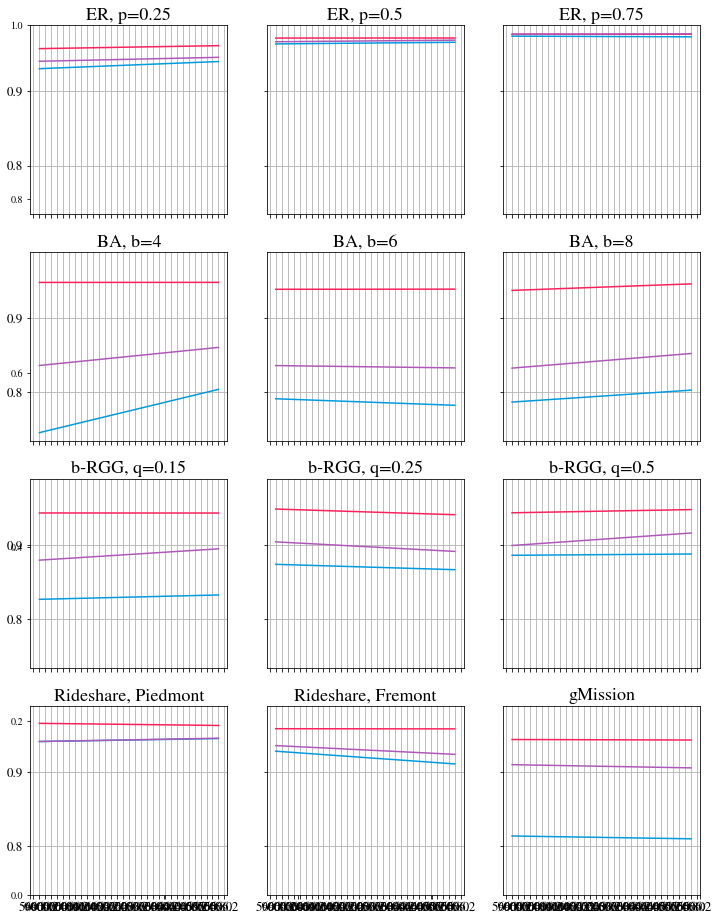

In [8]:
with open(f"experiments/transferability_gnn2_2.pickle", 'rb') as handle:
    results = pickle.load(handle)

filtered_results = {frozenset(g.items()): data for g, data in zip(graph_configs, results)}
_plot_approx_ratios_all(sizes, filtered_results, x_axis_name= "Total number of nodes $N$", confidence = 0.95)